In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
from tqdm import tqdm
# import pickle

import hexbin_functions as hexfunc

/nethome/6525954/.conda/envs/nemo-ensemble/lib/python3.12/site-packages/h3/unstable/__init__.py:4: UserWarning: Modules under `h3.unstable` are experimental, and may change at any time.
  warnings.warn(


In [67]:
def create_dataframe(probability_sets, entropy_sets, hexints):
    """
    Creates xarray Dataframe containing the probability and entropy data.

    Parameters
    ----------
    probability_sets : dict
        Dictionary containing probability data arrays for each delta_t.
    entropy_sets : dict
        Dictionary containing entropy data arrays for each delta_t.
    hexints : list
        List of hexagonal bin indices.
    obs_length : int
        The length of the observation period.
    filename : str
        The filename to save the NetCDF file.
    
    Returns
    -------
    ds : xarray.Dataset
        The dataset containing the probability and entropy data.
    """

    ds = xr.Dataset(
        {
            'probability': xr.DataArray(
                np.array([probability_sets[i] for i in range(0, 15)]),
                dims=['delta_t', 'hexint', 'time'],
                coords={
                    'delta_t': range(0, 15),
                    'hexint': hexints,
                    'time': range(probability_sets[0].shape[1])
                },
                attrs={
                    'description': 'Probability of occurrence for each time step, hexagonal bin, and observation time',
                    'units': 'probability'
                }
            ),
            'entropy': xr.DataArray(
                np.array([entropy_sets[i] for i in range(0, 15)]),
                dims=['delta_t', 'time'],
                coords={
                    'delta_t': range(0, 15),
                    'time': range(probability_sets[0].shape[1])
                },
                attrs={
                    'description': 'Entropy values for each time step and observation time',
                    'units': 'nats'
                }
            )
        }
    )
    
    return ds

In [46]:
def entropy(Pdf):
    # Pdf = Pdf / np.nansum(Pdf)  # Normalize Pdf to sum to 1, ignoring NaNs
    # Replace zeros with a very small number to avoid log(0)
    Pdf_safe = np.where(Pdf > 0, Pdf, np.finfo(float).eps)
    return -np.nansum(Pdf_safe * np.log(Pdf_safe))

def information(Pdf):
    Pdf_safe = np.where(Pdf > 0, Pdf, np.finfo(float).eps)
    return - Pdf_safe * np.log2(Pdf_safe)

def Shannon_entropy(Pdf):
    # Pdf = Pdf / np.nansum(Pdf)  # Normalize Pdf to sum to 1, ignoring NaNs
    # Replace zeros with a very small number to avoid log(0)
    Pdf_safe = np.where(Pdf > 0, Pdf, np.finfo(float).eps)
    return -np.nansum(Pdf_safe * np.log2(Pdf_safe))

In [3]:
location = 'Cape_Hatteras'
member = 50
std = 0.01

file_path = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}/P_std{std*100:03.0f}_m{member:03d}.zarr"
P_m = xr.open_zarr(file_path)

In [4]:
P_m['probability'].values.shape

(15, 4644, 1400)

In [68]:
hex_grid = hexfunc.int_to_hex(P_m.hexint.values)
hexbin_grid = hexfunc.hexGrid(hex_grid, h3_res=3)

# Make probability distributions for all members (available)

In [5]:
stds = np.linspace(1, 20, 20)/100

In [77]:
location = 'Cape_Hatteras'
members =  [1, 2, 47, 48, 49, 50]
stds = np.linspace(1, 20, 20)/100
N_gropus = len(P_m.delta_t)
N_bins = len(P_m.hexint)
N_times = len(P_m.time)

P_AX = np.zeros((N_gropus, N_bins, N_times))

    
for std in tqdm(stds):
    P_AX = np.zeros((N_gropus, N_bins, N_times))
    for member in members:

        file_path = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}/P_std{std*100:03.0f}_m{member:03d}.zarr"
        P_m = xr.open_zarr(file_path)
        
        P_AX += P_m['probability'].values
        
    P_AX_norm = np.zeros_like(P_AX)

    H_AX = np.zeros((N_gropus, N_times))

    for gap in range(N_gropus):
        for t in range(N_times):
            P_AX_norm[gap, :, t] = P_AX[gap, :, t]/P_AX[gap, :, t].sum()
            H_AX[gap, t] = entropy(P_AX_norm[gap, :, t])
            
    P_AX = P_AX_norm
    
    DF_std = create_dataframe(P_AX, H_AX, P_m.hexint.values)
    DF_std.to_zarr(f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}/P_std{std*100:03.0f}_all.zarr")

  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_725870/1919637471.py:26: RuntimeWarning: invalid value encountered in divide
  P_AX_norm[gap, :, t] = P_AX[gap, :, t]/P_AX[gap, :, t].sum()
100%|██████████| 20/20 [03:11<00:00,  9.55s/it]


# Load the files

In [ ]:
hex_grid = hexfunc.int_to_hex(P_m.hexint.values)
hexbin_grid = hexfunc.hexGrid(hex_grid, h3_res=3)

In [91]:
std = 0.01
P_AX_001 = xr.open_zarr(f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}/P_std{std*100:03.0f}_all.zarr")

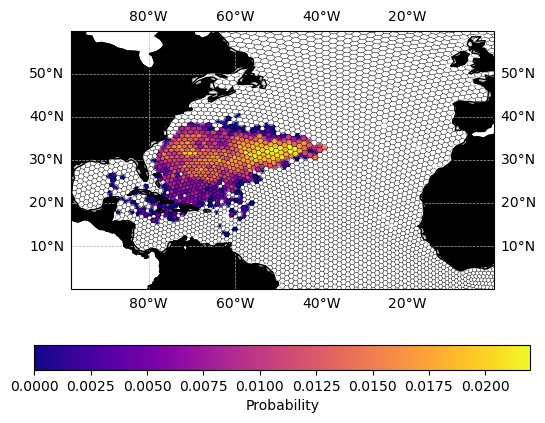

In [113]:
# Plot NA_domain on a map
depth = 0
fig = plt.figure()
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.set_extent([-98, 0, 0, 60], crs=cartopy.crs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.LAND, zorder=0, color='black')
ax.gridlines(draw_labels=True, zorder=0, linestyle='--', linewidth=0.5)

t = 365
t_gap = 1

im = hexbin_grid.pcolorhex(P_AX_001['probability'][t_gap, :, t].values, ax=ax, cmap='plasma', draw_edges=True)
# add colorbar
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', label='Probability')

Text(0, 0.5, 'Time (days)')

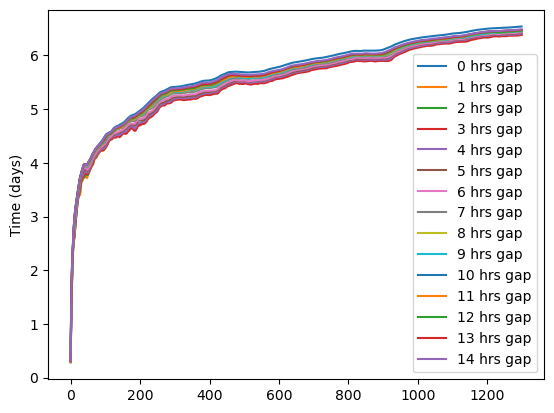

In [99]:
for delta_t in range(0, 15):
    plt.plot(H_AX[delta_t, :1300], label=f'{delta_t} hrs gap')
    
plt.legend()
plt.ylabel('Entropy (nats)')
plt.ylabel('Time (days)')

8it [00:29,  3.64s/it]
/tmp/ipykernel_725870/3411516422.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


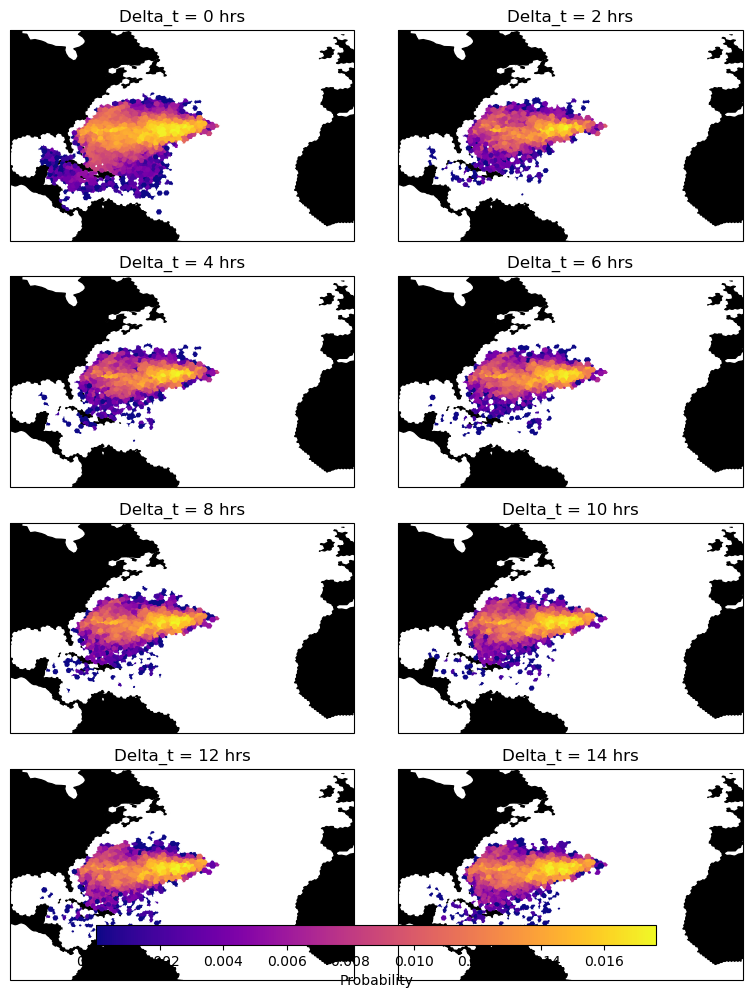

In [128]:
t = 365
fig, axs = plt.subplots(4, 2, figsize=(8, 10), subplot_kw={'projection': cartopy.crs.PlateCarree()})
axs = np.ravel(axs)

# Determine global vmin and vmax for consistent color scaling across subplots

for i, ax in tqdm(enumerate(axs)):
    ax.set_extent([-98, 0, 0, 60], crs=cartopy.crs.PlateCarree())
    # ax.coastlines()
    ax.add_feature(cartopy.feature.LAND, zorder=0, color='black')

    im = hexbin_grid.pcolorhex(P_AX_001['probability'][i*2, :, t].values, ax=ax, cmap='plasma', draw_edges=False)
    ax.set_title(f'Delta_t = {i*2} hrs')

# Add a colorbar to the figure, associated with the last subplot's mappable
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.02])  # Adjust these values as needed

cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', label='Probability')

plt.tight_layout()